In [1]:
import glob
import gzip
import operator as op
import typing as t
import re
from collections import Counter
from concurrent.futures import ProcessPoolExecutor


import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from fn import F
from fn.iters import group_by

%matplotlib inline

In [2]:
annotation_paths = glob.glob('assemblies/*.gbff.gz')
len(annotation_paths)

18207

In [3]:
# extract sample IDs and make output paths
id_patt = re.compile('(GCF_[0-9.]+)')
ids = [id_patt.findall(path)[0] for path in annotation_paths]

In [4]:
def parse_gzipped_gb(path: str) -> t.List[SeqRecord]:
    with gzip.open(path, 'rt') as buffer:
        return list(SeqIO.parse(buffer, 'gb'))


def extract_species(assembly: t.List[SeqRecord]) -> str:
    largest_chrom = max(assembly, key=len)
    organism = largest_chrom.annotations['organism']
    # we ignore subspecies division
    return (
        # Candidatus names comprise three words
        ' '.join(organism.split()[:3]) if organism.startswith('Candidatus') else
        # Regular names comprise two words
        ' '.join(organism.split()[:2])
    )

In [6]:
def parse_gb_and_extract_species(path: str) -> str:
    return extract_species(parse_gzipped_gb(path))


with ProcessPoolExecutor(20) as workers:
    species = list(
        tqdm.tqdm(
            workers.map(parse_gb_and_extract_species, annotation_paths), 
            total=len(annotation_paths)
        )
    )

100%|██████████| 18207/18207 [14:44<00:00, 20.59it/s]


In [7]:
# filter assembly ids by species: get rid of assemblies without a proper or complete species name

pairs = pd.DataFrame({'id': ids, 'species': species})
pairs_filtered = (
    pairs
    .groupby('species')
    .filter(lambda grp: not (grp.name.endswith('endosymbiont') or grp.name.endswith('sp.')))
)
pairs_filtered.to_csv('samples.tsv', sep='\t', index=False)
pairs_filtered.head()

,id,species
0,GCF_002881935.1,Streptococcus agalactiae
3,GCF_000013405.1,Syntrophus aciditrophicus
4,GCF_000427275.1,Mannheimia haemolytica
5,GCF_003325015.1,Salmonella enterica
6,GCF_002313025.1,Vibrio cholerae


In [8]:
assembly_stats = pairs_filtered['species'].value_counts()

In [9]:
! mkdir -p figures

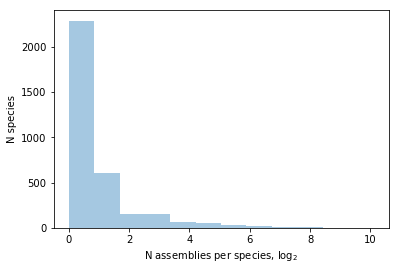

In [10]:
coverage = sns.distplot(np.log(assembly_stats) / np.log(2), kde=False, bins=12)
coverage.set_xlabel('N assemblies per species, $\log_2$')
coverage.set_ylabel('N species')
plt.savefig('figures/coverage.png', dpi=300)
